In [1]:
import numpy as np
import pandas as pd #to read files or work with dataframes
import yfinance as yf
import datetime as datetime #to specify start and end dates
import matplotlib.pyplot as plt #to visualize
from matplotlib import style
import pandas_datareader as dr #to collect data
from pandas_datareader import data
import cvxpy as cp
import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco

%matplotlib inline

In [2]:
#Parameter set up:
n_portfolios = 5000
n_days = 252
assets = ['BARC.L', 'GSK.L', 'BP.L', 'BATS.L', 'AVV.L', 'GLEN.L', 'SGRO.L', 'OCDO.L', 'JD.L', 'SGE.L', 'PSN.L', 'VOD.L', 'AHT.L', 'FERG.L', 'BA.L']
assets.sort()
start_date = '2020-01-01'
end_date = '2022-04-25'

n_assets = len(assets)

In [3]:
#Downloading stockprices from Yahoo Finance:
prices = yf.download(assets, start=start_date, end=end_date, adjusted=True)

[*********************100%***********************]  15 of 15 completed


In [4]:
#Calculation of Annualised Average Returns and the corresponding Standard Deviation:
returns = prices['Adj Close'].pct_change().dropna()
returns

,AHT.L,AVV.L,BA.L,BARC.L,BATS.L,BP.L,FERG.L,GLEN.L,GSK.L,JD.L,OCDO.L,PSN.L,SGE.L,SGRO.L,VOD.L
Date,,,,,,,,,,,,,,,
2020-01-03,-0.006250,-0.004243,0.011847,-0.010259,0.026646,0.027451,0.004013,0.002489,0.004051,-0.024296,0.004764,-0.016117,-0.012306,-0.004444,0.000947
2020-01-06,0.007966,-0.003835,0.013430,-0.012657,-0.000597,0.020342,-0.014273,-0.022140,-0.007846,0.006410,0.004741,0.001117,-0.002980,-0.005580,-0.005813
2020-01-07,-0.002496,0.010265,0.002718,0.011935,0.016716,-0.010514,0.006082,0.002962,-0.004519,0.000490,0.042470,0.014132,-0.001358,-0.008530,-0.002855
2020-01-08,0.012093,0.006774,0.003050,-0.006006,0.018644,-0.009021,0.004606,0.011814,0.004993,0.002693,0.006413,-0.001467,-0.001904,-0.005886,0.005727
2020-01-09,0.018954,0.006645,0.001689,0.004504,-0.003026,-0.004552,0.023782,-0.005630,0.010727,0.010256,-0.043103,0.002571,0.011720,-0.007060,0.030237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,-0.002832,-0.010242,0.006840,0.011091,-0.000460,0.005285,0.011100,-0.006225,-0.004604,-0.000339,-0.013004,0.015918,0.001384,0.013806,0.003493
2022-04-19,0.003058,0.002070,-0.007055,-0.001097,0.004598,0.004005,0.022954,0.016705,-0.007558,-0.030169,0.003953,0.006912,-0.004424,-0.002576,-0.013319
2022-04-20,0.040070,0.015696,0.006053,0.021826,0.011291,0.000249,0.035122,-0.031180,-0.010684,0.010136,-0.053368,0.013730,-0.003055,0.007749,-0.014726


In [5]:
avg_returns = returns.mean()* n_days
avg_returns

AHT.L     0.392154
AVV.L    -0.083242
BA.L      0.216696
BARC.L    0.041712
BATS.L    0.120962
BP.L      0.075509
FERG.L    0.262734
GLEN.L    0.472480
GSK.L     0.070394
JD.L      0.071269
OCDO.L    0.018869
PSN.L     0.112340
SGE.L     0.056683
SGRO.L    0.252810
VOD.L     0.047243
dtype: float64

In [6]:
cov_mat = returns.cov() * n_days
cov_mat

,AHT.L,AVV.L,BA.L,BARC.L,BATS.L,BP.L,FERG.L,GLEN.L,GSK.L,JD.L,OCDO.L,PSN.L,SGE.L,SGRO.L,VOD.L
AHT.L,0.190891,0.077905,0.052882,0.117332,0.044538,0.094156,0.108237,0.094088,0.036168,0.125619,0.015641,0.100744,0.050577,0.040713,0.051943
AVV.L,0.077905,0.161465,0.026785,0.060001,0.025978,0.051459,0.065934,0.058573,0.029991,0.090332,0.048376,0.065706,0.054683,0.048011,0.034946
BA.L,0.052882,0.026785,0.088811,0.060257,0.031591,0.061641,0.039511,0.055108,0.025503,0.049740,0.001208,0.048939,0.023174,0.020373,0.035445
BARC.L,0.117332,0.060001,0.060257,0.218743,0.050455,0.134251,0.087424,0.131381,0.030951,0.136419,-0.020517,0.119023,0.034378,0.039376,0.076383
BATS.L,0.044538,0.025978,0.031591,0.050455,0.074709,0.056675,0.035137,0.048193,0.030999,0.029402,0.012675,0.030217,0.022456,0.019544,0.044343
BP.L,0.094156,0.051459,0.061641,0.134251,0.056675,0.207837,0.059516,0.128717,0.037386,0.086770,-0.033088,0.073805,0.024492,0.024447,0.068678
FERG.L,0.108237,0.065934,0.039511,0.087424,0.035137,0.059516,0.113002,0.073849,0.029983,0.099092,0.023466,0.087520,0.044131,0.042128,0.039293
GLEN.L,0.094088,0.058573,0.055108,0.131381,0.048193,0.128717,0.073849,0.194470,0.032031,0.085070,-0.003131,0.086012,0.027759,0.037732,0.057676
GSK.L,0.036168,0.029991,0.025503,0.030951,0.030999,0.037386,0.029983,0.032031,0.053178,0.023709,0.018669,0.027811,0.023183,0.017071,0.029600
JD.L,0.125619,0.090332,0.049740,0.136419,0.029402,0.086770,0.099092,0.085070,0.023709,0.263094,-0.005312,0.137580,0.042623,0.056653,0.043804


In [7]:
prices = pd.DataFrame()
for tick in assets:
    prices[tick] = data.DataReader(tick, data_source='yahoo', start='2020-01-01', end='2022-04-25')['Adj Close']
prices.columns = assets
    
prices

,AHT.L,AVV.L,BA.L,BARC.L,BATS.L,BP.L,FERG.L,GLEN.L,GSK.L,JD.L,OCDO.L,PSN.L,SGE.L,SGRO.L,VOD.L
Date,,,,,,,,,,,,,,,
2020-01-02,2341.296387,3688.335205,499.802399,171.548981,2752.842529,414.027252,6539.430176,200.162445,1574.029541,166.014893,1259.5,2217.925781,699.369141,838.127380,132.728622
2020-01-03,2326.663086,3672.686768,505.723419,169.789062,2826.195557,425.392944,6565.669922,200.660690,1580.406494,161.981339,1265.5,2182.179199,690.762695,834.402344,132.854340
2020-01-06,2345.198242,3658.603271,512.515137,167.640045,2824.509521,434.046265,6471.954590,196.218140,1568.006836,163.019684,1271.5,2184.616455,688.704590,829.746033,132.082031
2020-01-07,2339.345215,3696.159912,513.908386,169.640839,2871.724609,429.482788,6511.315430,196.799408,1560.921509,163.099548,1325.5,2215.488281,687.769104,822.668640,131.704880
2020-01-08,2367.635742,3721.197266,515.475708,168.621918,2925.264160,425.608124,6541.304199,199.124466,1568.715576,163.538849,1334.0,2212.238525,686.459412,817.826050,132.459213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-19,4592.000000,2421.000000,744.891418,145.699997,3277.000000,395.835083,10250.000000,522.181580,1759.599976,143.050003,1143.0,2185.000000,720.200012,1355.000000,130.380005
2022-04-20,4776.000000,2459.000000,749.399963,148.880005,3314.000000,395.933807,10610.000000,505.900024,1740.800049,144.500000,1082.0,2215.000000,718.000000,1365.500000,128.460007
2022-04-21,4817.000000,2521.000000,741.200012,150.059998,3344.500000,397.907776,10790.000000,489.700012,1744.800049,147.250000,1090.0,2247.000000,727.200012,1377.000000,128.500000


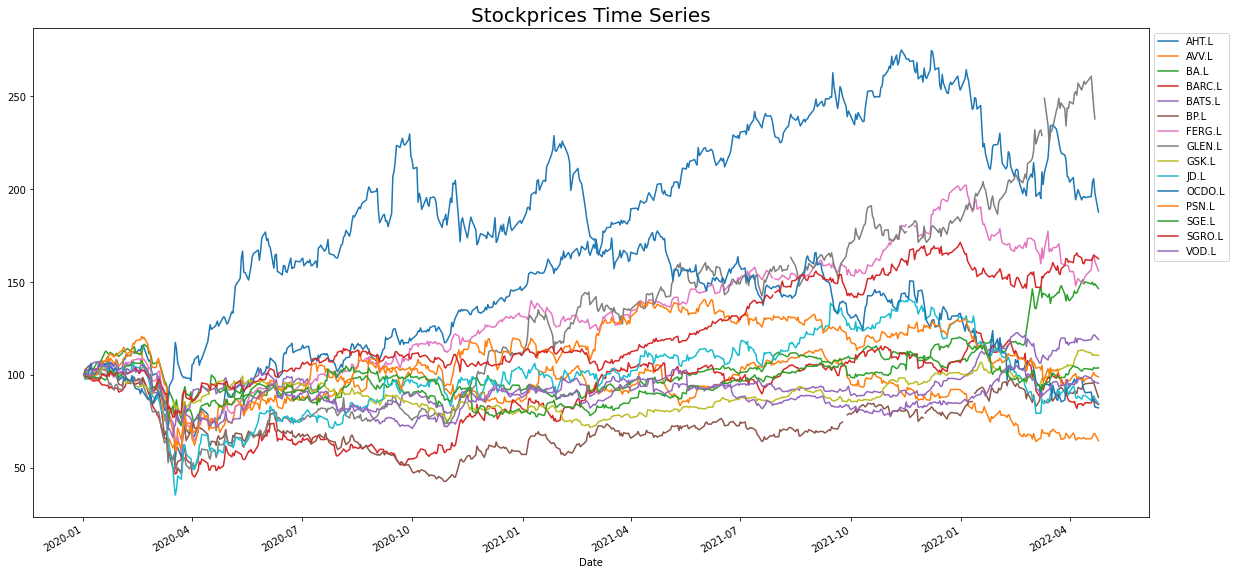

In [8]:
# Plotting the timeseries:
timeseries = prices / prices.iloc[0] * 100
timeseries.plot(figsize=(20, 10))
plt.title('Stockprices Time Series', fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

In [9]:
#Simulation of random portfolio weights:
np.random.seed(42)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /= np.sum(weights, axis=1) [:, np.newaxis]
weights

array([[0.05048753, 0.12815507, 0.09867184, ..., 0.1122122 , 0.02862304,
        0.02450977],
       [0.03195507, 0.05300896, 0.09142975, ..., 0.08959647, 0.10321801,
        0.00809318],
       [0.08789189, 0.02466927, 0.00941084, ..., 0.0049749 , 0.13154895,
        0.03743701],
       ...,
       [0.06487339, 0.06852885, 0.03105956, ..., 0.09980353, 0.0785815 ,
        0.03340515],
       [0.10065993, 0.08146337, 0.10273879, ..., 0.08119449, 0.10355966,
        0.00815193],
       [0.03206772, 0.09778411, 0.09759084, ..., 0.12010146, 0.12071243,
        0.00894861]])

In [10]:
portf_returns = np.dot(weights, avg_returns)

portf_vol = np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_returns / portf_vol

In [11]:
portf_results = pd.DataFrame({'returns': portf_returns,
                             'volatility': portf_vol,
                             'sharpe_ratio': portf_sharpe_ratio})
portf_results

,returns,volatility,sharpe_ratio
0,0.137235,0.260537,0.526739
1,0.123895,0.224313,0.552330
2,0.139356,0.253136,0.550518
3,0.160825,0.248538,0.647084
4,0.162795,0.244062,0.667022
...,...,...,...
4995,0.125896,0.235613,0.534334
4996,0.121094,0.226762,0.534015
4997,0.131608,0.244273,0.538773
4998,0.164807,0.247291,0.666449


In [12]:
n_points = 20
portf_vol_ef = []
indices_to_skip = []

portf_returns_ef = np.linspace(portf_results.returns.min(),
                               portf_results.returns.max(),
                               n_points)
portf_rerturns_ef = np.round(portf_returns_ef, 2)
portf_returns = np.round(portf_returns, 2)

for point_index in range (n_points):
    if portf_returns_ef[point_index] not in portf_returns:
       indices_to_skip.append(point_index)
       continue
    matched_ind = np.where(portf_returns ==
                           portf_returns_ef[point_index])
    
portf_returns_ef = np.delete(portf_returns_ef, indices_to_skip)

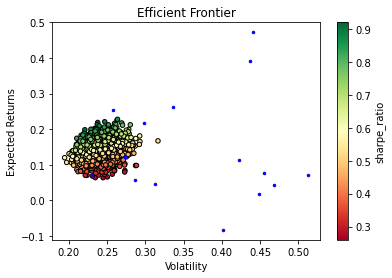

In [13]:
marks = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


fig, ax = plt.subplots()
portf_results.plot(kind='scatter', 
                   x='volatility', 
                   y='returns', 
                   c='sharpe_ratio', 
                   cmap='RdYlGn', 
                   edgecolors='black', 
                   ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_returns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=marks[asset_index],
               s=25,
               color='blue',
               label=())

In [14]:
max_sharpe_ind = np.argmax(portf_results.sharpe_ratio)
max_sharpe_portf = portf_results.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results.volatility)
min_vol_portf = portf_results.loc[min_vol_ind]

In [15]:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')
for index, value in max_sharpe_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmax(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.88% volatility: 23.78% sharpe_ratio: 91.99% 
Weights
AHT.L: 0.83% AVV.L: 2.69% BA.L: 21.53% BARC.L: 6.88% BATS.L: 2.52% BP.L: 2.34% FERG.L: 15.71% GLEN.L: 18.65% GSK.L: 5.61% JD.L: 0.46% OCDO.L: 4.87% PSN.L: 1.23% SGE.L: 2.26% SGRO.L: 9.42% VOD.L: 5.02% 

In [16]:
print ('Minimum Volatility portfolio ----')
print ('Performance')
for index, value in min_vol_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmin(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 11.98% volatility: 19.46% sharpe_ratio: 61.57% 
Weights
AHT.L: 1.32% AVV.L: 10.83% BA.L: 4.32% BARC.L: 15.74% BATS.L: 1.92% BP.L: 14.69% FERG.L: 1.54% GLEN.L: 0.44% GSK.L: 4.10% JD.L: 5.80% OCDO.L: 10.92% PSN.L: 2.30% SGE.L: 7.62% SGRO.L: 3.56% VOD.L: 14.91% 

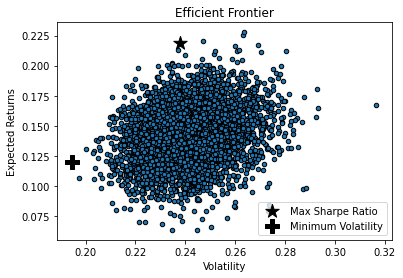

In [17]:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black',
           marker='*',
           s=200,
           label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black',
           marker='P',
           s=200,
           label='Minimum Volatility')
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

In [18]:
# Define functions for calculating portfolio return and volatility:

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [19]:
# Define the function calculating theEfficient Frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range (n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

In [20]:
# Define the considered range of returns
rtns_range = np.linspace (0.1, 0.32, 200)

In [21]:
# Calculate the Efficient Frontier
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [22]:
# Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

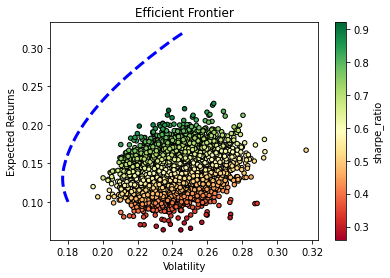

In [23]:
# Plot the calculated Efficient Frontier, together with the simulated portfolios:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   c='sharpe_ratio',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

In [24]:
# Identify the minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Voltatility': min_vol_portf_rtn,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

In [25]:
# Print the performance summary:
print ('Minimum volatility portfolio ----')
print ('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets,
efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum volatility portfolio ----
Performance
Return: 12.98% Voltatility: 12.98% Sharpe Ratio: 73.32% 
Weights
AHT.L: 0.00% AVV.L: 0.00% BA.L: 12.11% BARC.L: 0.00% BATS.L: 10.00% BP.L: 0.00% FERG.L: 0.00% GLEN.L: 0.00% GSK.L: 28.21% JD.L: 0.00% OCDO.L: 7.03% PSN.L: 0.00% SGE.L: 11.55% SGRO.L: 23.88% VOD.L: 7.22% 

In [26]:
# Define the objective function for the negative Sharpe Ratio:

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate) :
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [27]:
# Finding the optimized portfolio:
n_assets = len(avg_returns)
rf_rate = 0.01

args = (avg_returns, cov_mat, rf_rate)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range (n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [28]:
# Extracting information about the maximu Sharpe Ratio portfolio:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                            avg_returns,
                                            cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [29]:
# Printing performance summary:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100*value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 33.40% Volatility: 25.71% Sharpe Ratio: 126.02% 
Weights
AHT.L: 13.20% AVV.L: 0.00% BA.L: 10.22% BARC.L: 0.00% BATS.L: 0.00% BP.L: 0.00% FERG.L: 0.00% GLEN.L: 30.27% GSK.L: 0.00% JD.L: 0.00% OCDO.L: 0.00% PSN.L: 0.00% SGE.L: 0.00% SGRO.L: 46.31% VOD.L: 0.00% 

In [30]:
# Convert the annualised average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [31]:
# Set up the optimization problem
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function,
                     [cp.sum(weights) == 1, weights>= 0])

In [32]:
# Calculate the Efficient Frontier
n_points = 20
portf_rtn_cvx_ef = np.zeros(n_points)
portf_vol_cvx_ef = np.zeros(n_points)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=n_points)

for i in range (n_points) :
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

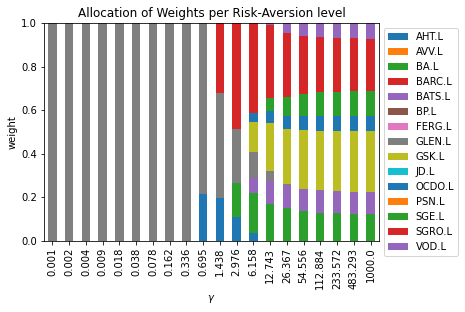

In [33]:
# Plot the allocation for different values of the risk-aversion parameter
weights_df = pd.DataFrame(weights_ef,
                          columns=assets,
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Allocation of Weights per Risk-Aversion level',
       xlabel=r'$\gamma$',
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

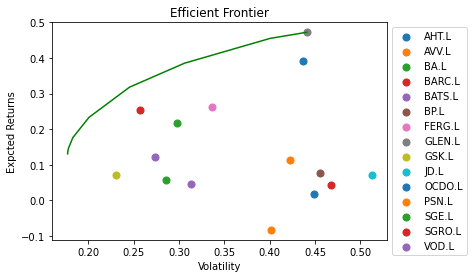

In [34]:
# Plotting the Efficient Frontier with individual assets
MARKS = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                 y=avg_returns[asset_index],
                 marker=MARKS[asset_index],
                 label=assets[asset_index],
                 s=200)
ax.set(title='Efficient Frontier',
       xlabel='Volatility',
       ylabel='Expcted Returns', )
ax.legend(bbox_to_anchor=(1,1))

[Text(0.5, 1.0, 'Maximized Risk-Adjusted Retrun'),
 Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 (0.1, 0.5),
 (0.1, 0.75)]

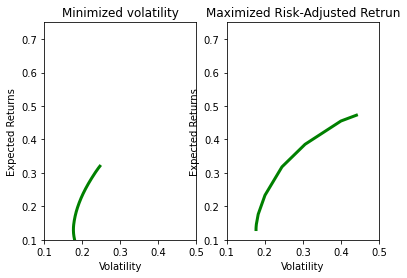

In [35]:
# Efficient frontier comparison
x_lim = [0.1, 0.5]
y_lim = [0.1, 0.75]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Minimized volatility',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Maximized Risk-Adjusted Retrun',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

In [36]:
# Analysing maximum allowable leverage
max_leverage= cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                   [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In [37]:
# Redefining objects in order to store the results to be either larger 2D matrices or 3 = [1, 2, 5]
leverage_range = [1, 3, 5]
len_leverage = len(leverage_range)
n_points = 20

portf_vol_l_ef = np.zeros((n_points, len_leverage))
portf_rtn_l_ef = np.zeros((n_points, len_leverage))
weights_ef =np.zeros((len_leverage, n_points, n_assets))

for lev_ind, leverage in enumerate(leverage_range) :
    for gamma_ind in range(n_points):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(verbose=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 12 06:06:11 AM: Your problem has 15 variables, 2 constraints, and 2 parameters.
(CVXPY) May 12 06:06:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 06:06:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 06:06:11 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 12 06:06:11 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) May 12 06:06:11 AM: Applying reduction FlipObjective
(CVXPY) May 12 06:06:11 AM: Applying reductio

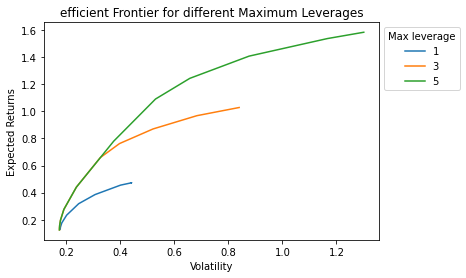

In [38]:
# Efficient frontiers for dfferent maximum leverages
fig, ax=plt.subplots()

for leverage_index, leverage in enumerate(leverage_range):
    plt.plot(portf_vol_l_ef[:, leverage_index],
            portf_rtn_l_ef[:, leverage_index],
            label=f'{leverage}')
    
ax.set(title='efficient Frontier for different Maximum Leverages',
       xlabel='Volatility',
       ylabel='Expected Returns')
ax.legend(title='Max leverage',
          bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'Weights allocation per risk-aversion level')

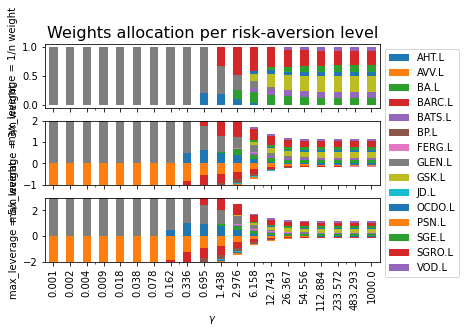

In [39]:
# Plotting weight allocation per varying risk-aversion levels
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame (weights_ef[ax_index],
                               columns=assets,
                               index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True,
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {leverage_range[ax_index]}'
                             '/n weight'))
    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)